In [1]:
Nmesh = 128
import matplotlib.pyplot as plt

In [2]:
import pyccl as ccl
from LIMxCMBL.init import *

In [3]:
import h5py
import hdf5plugin

In [4]:
from nbodykit.source.catalog import ArrayCatalog

In [5]:
parts = np.zeros(512**3, dtype=[('Position', ('f4', 3))])

c = 0
snapno = 4
for i in range(8):
    snap = h5py.File('/home/users/kokron/scratch/0/'+'snapdir_%03d/snap_%03d.%d.hdf5'%(snapno,snapno,i), 'r')
    snapu = snap['PartType1']['Coordinates'][...]

    lensnap = len(snapu)
    parts['Position'][c:c+lensnap] = snapu / 1000

    c+=lensnap

    snap.close()

In [6]:
f = ArrayCatalog(parts)

fmesh = f.to_mesh(Nmesh=Nmesh, BoxSize=250)
df = fmesh.paint()
df/= np.mean(df)

In [7]:
print(df.value.mean())
print(df.value.min())
print(df.value.max())

0.99999976
0.2747101
19.466557


In [8]:
colors = np.ones((Nmesh,Nmesh,Nmesh,)+ (4,))
# colors[...,-1] = df/np.max(df)
colors[...,0] = 0
colors[...,1] = 0
colors[...,2] = 0
colors[...,3] = df.value/np.max(df)/25


In [9]:
import types
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D, art3d  # NOQA

In [10]:
#from https://stackoverflow.com/questions/48672663/matplotlib-render-all-internal-voxels-with-alpha
def voxels(self, *args, **kwargs):

    if len(args) >= 3:
        # underscores indicate position only
        def voxels(__x, __y, __z, filled, **kwargs):
            return (__x, __y, __z), filled, kwargs
    else:
        def voxels(filled, **kwargs):
            return None, filled, kwargs

    xyz, filled, kwargs = voxels(*args, **kwargs)

    # check dimensions
    if filled.ndim != 3:
        raise ValueError("Argument filled must be 3-dimensional")
    size = np.array(filled.shape, dtype=np.intp)

    # check xyz coordinates, which are one larger than the filled shape
    coord_shape = tuple(size + 1)
    if xyz is None:
        x, y, z = np.indices(coord_shape)
        
    def _broadcast_color_arg(color, name):
        if np.ndim(color) in (3, 4):
            # 3D array of strings, or 4D array with last axis rgb
            if np.shape(color)[:3] != filled.shape:
                raise ValueError(
                    "When multidimensional, {} must match the shape of "
                    "filled".format(name))
            return color
        else:
            raise ValueError("Invalid {} argument".format(name))

    # intercept the facecolors, handling defaults and broacasting
    facecolors = kwargs.pop('facecolors', None)
    if facecolors is None:
        facecolors = self._get_patches_for_fill.get_next_color()
    facecolors = _broadcast_color_arg(facecolors, 'facecolors')

    # broadcast but no default on edgecolors
    edgecolors = kwargs.pop('edgecolors', None)
    edgecolors = _broadcast_color_arg(edgecolors, 'edgecolors')

    # include possibly occluded internal faces or not
    internal_faces = kwargs.pop('internal_faces', False)

    # always scale to the full array, even if the data is only in the center
    self.auto_scale_xyz(x, y, z)

    # points lying on corners of a square
    square = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [1, 0, 0]
    ], dtype=np.intp)

    voxel_faces = defaultdict(list)

    def permutation_matrices(n):
        """ Generator of cyclic permutation matices """
        mat = np.eye(n, dtype=np.intp)
        for i in range(n):
            yield mat
            mat = np.roll(mat, 1, axis=0)

    for permute in permutation_matrices(3):
        pc, qc, rc = permute.T.dot(size)
        pinds = np.arange(pc)
        qinds = np.arange(qc)
        rinds = np.arange(rc)

        square_rot = square.dot(permute.T)

        for p in pinds:
            for q in qinds:
                p0 = permute.dot([p, q, 0])
                i0 = tuple(p0)
                if filled[i0]:
                    voxel_faces[i0].append(p0 + square_rot)

                # draw middle faces
                for r1, r2 in zip(rinds[:-1], rinds[1:]):
                    p1 = permute.dot([p, q, r1])
                    p2 = permute.dot([p, q, r2])
                    i1 = tuple(p1)
                    i2 = tuple(p2)
                    if filled[i1] and (internal_faces or not filled[i2]):
                        voxel_faces[i1].append(p2 + square_rot)
                    elif (internal_faces or not filled[i1]) and filled[i2]:
                        voxel_faces[i2].append(p2 + square_rot)

                # draw upper faces
                pk = permute.dot([p, q, rc-1])
                pk2 = permute.dot([p, q, rc])
                ik = tuple(pk)
                if filled[ik]:
                    voxel_faces[ik].append(pk2 + square_rot)

    # iterate over the faces, and generate a Poly3DCollection for each voxel
    polygons = {}
    for coord, faces_inds in voxel_faces.items():
        # convert indices into 3D positions
        if xyz is None:
            faces = faces_inds
        else:
            faces = []
            for face_inds in faces_inds:
                ind = face_inds[:, 0], face_inds[:, 1], face_inds[:, 2]
                face = np.empty(face_inds.shape)
                face[:, 0] = x[ind]
                face[:, 1] = y[ind]
                face[:, 2] = z[ind]
                faces.append(face)

        poly = art3d.Poly3DCollection(faces,
            facecolors=facecolors[coord],
            edgecolors=edgecolors[coord],
            **kwargs
        )
        self.add_collection3d(poly)
        polygons[coord] = poly

    return polygons

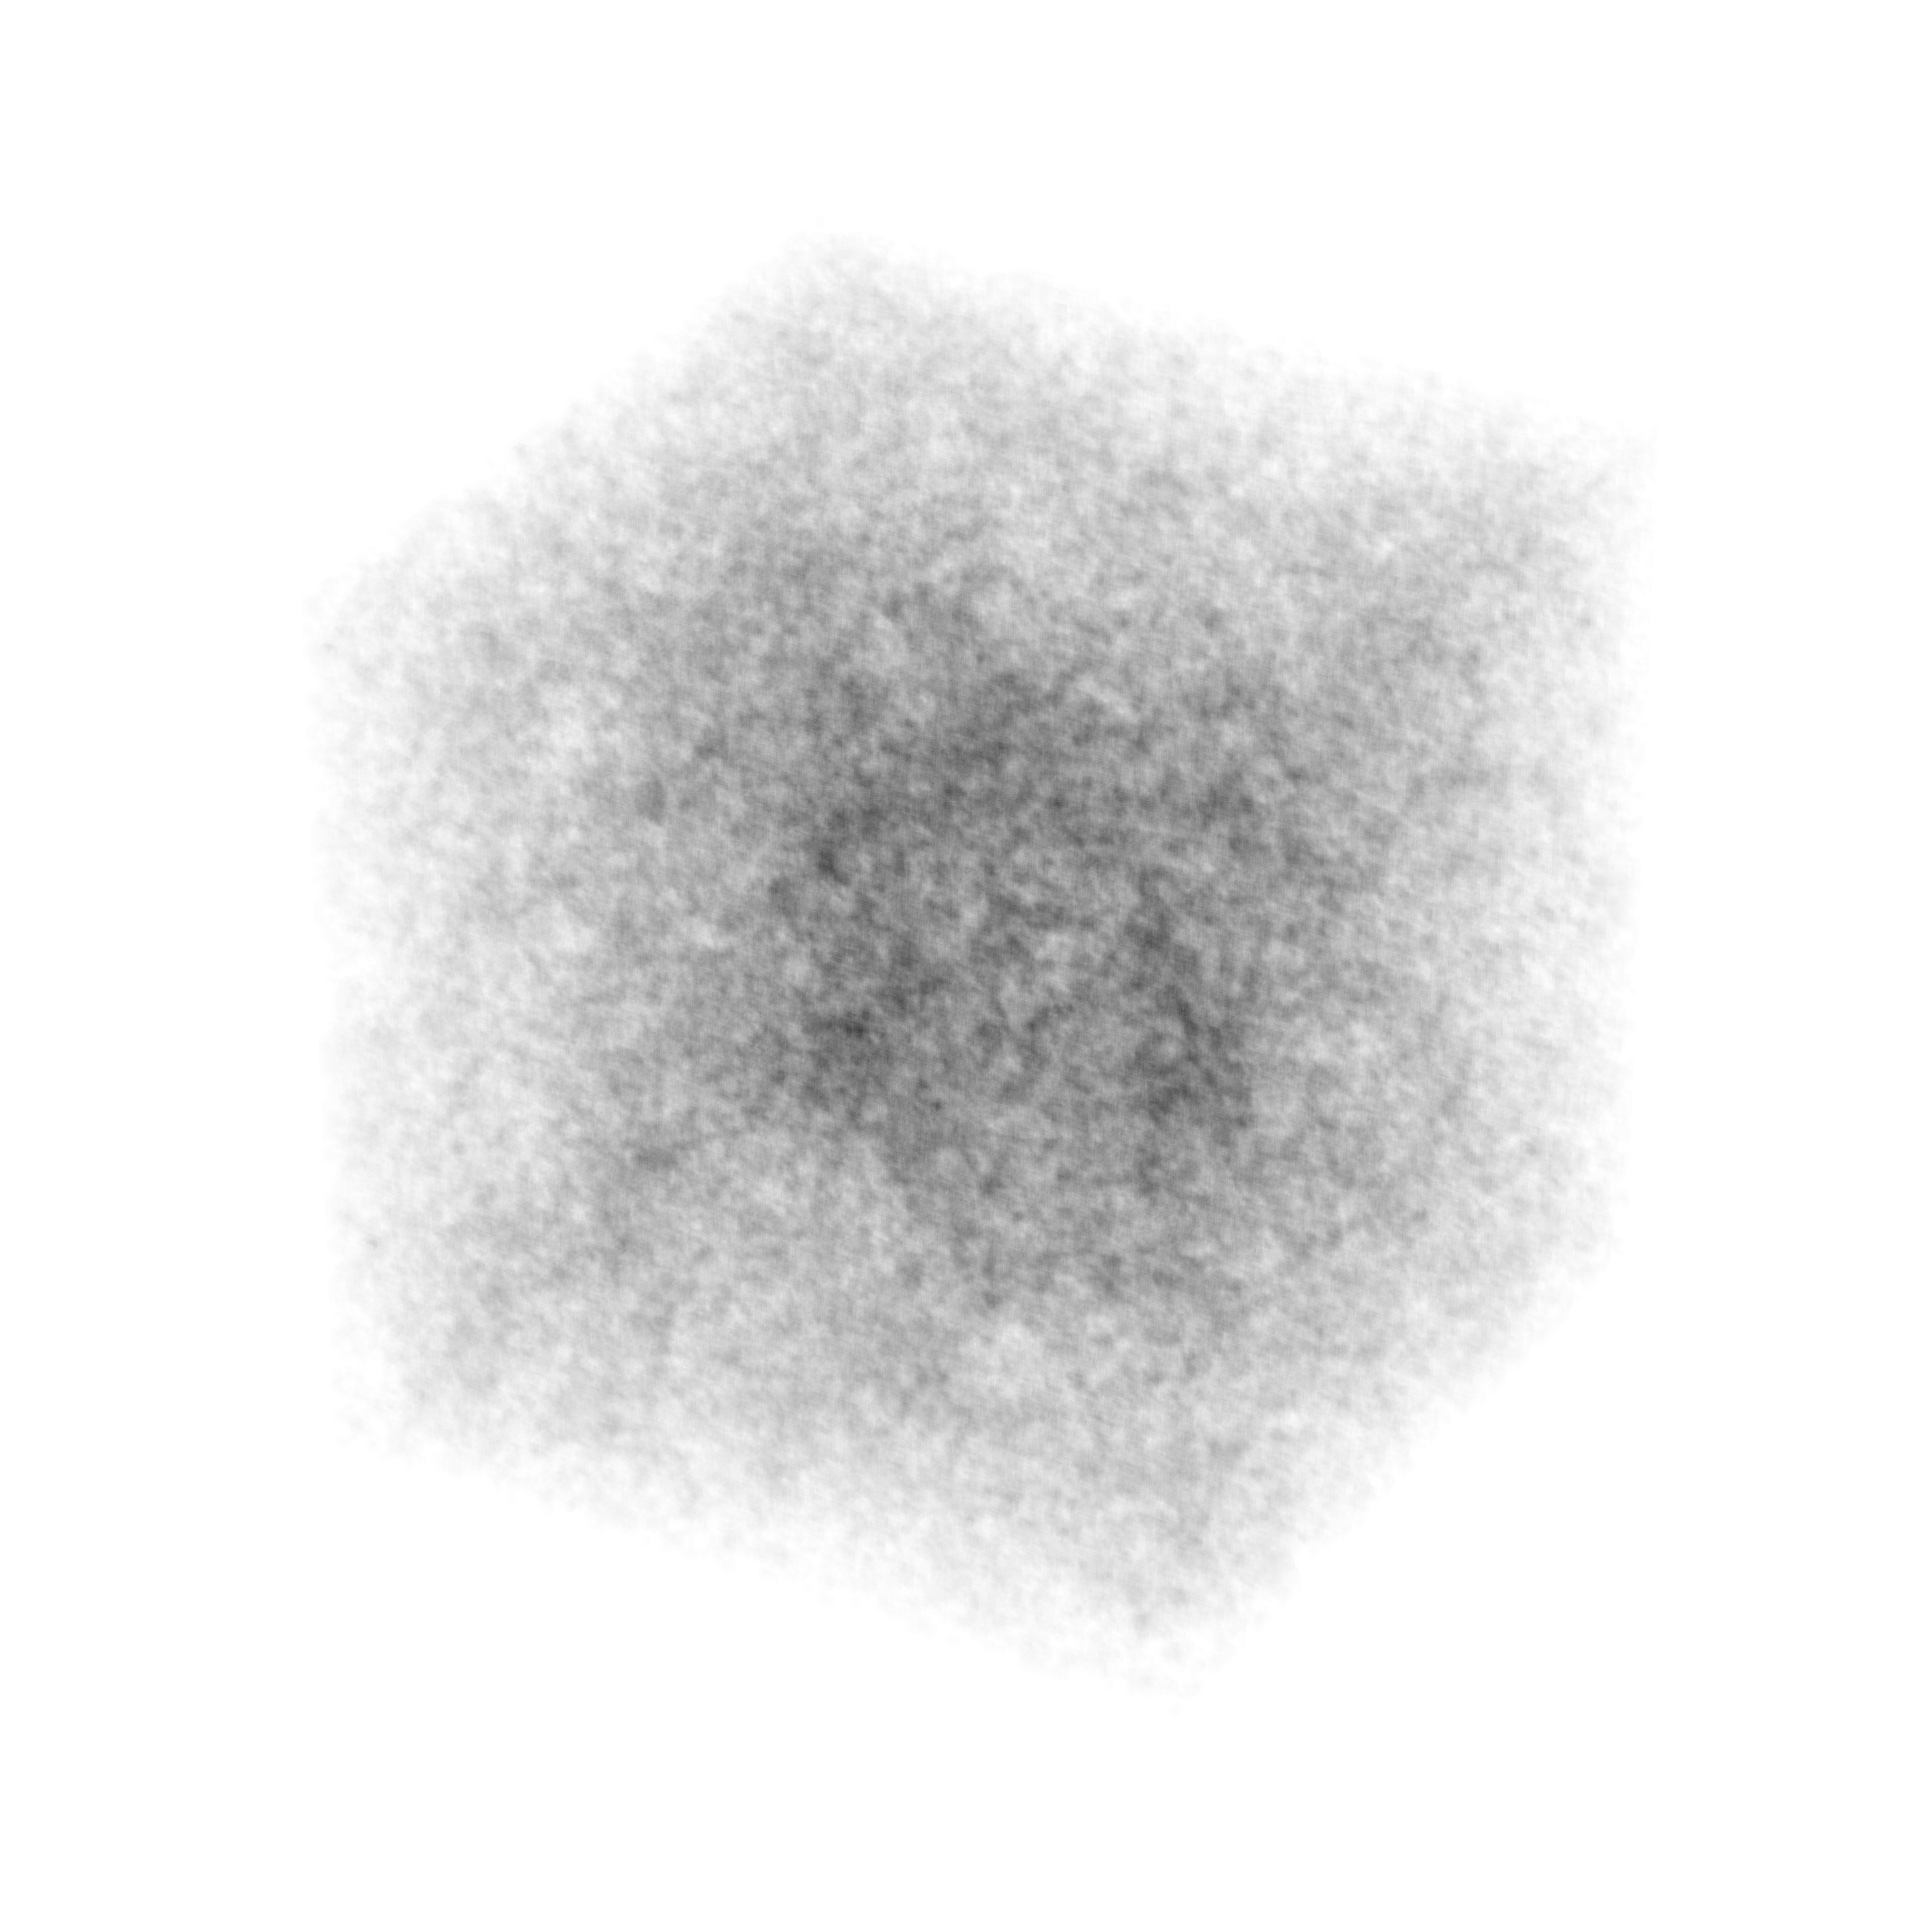

In [11]:
filled = np.ones((Nmesh,Nmesh,Nmesh))
fig = plt.figure(dpi=600)




ax = fig.add_subplot(projection='3d')

ax.voxels = types.MethodType(voxels, ax)
ax.voxels(filled, 
#           shade=False,
          facecolors=colors, 
          edgecolors=colors,
          internal_faces=True,
         lw=0,)
ax.axis('off')

xlim = ax.get_xlim3d()
ylim = ax.get_ylim3d()
zlim = ax.get_zlim3d()
ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

ax.set_rasterized(True)


plt.savefig('figures/016.000.delta_plus_one_Nmesh_%d.pdf'%(Nmesh), bbox_inches='tight')
plt.show()